In [2]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset'
od.download(dataset_url)

import pandas as pd

Skipping, found downloaded files in "./the-movies-dataset" (use force=True to force download)


In [3]:
metadata = pd.read_csv('the-movies-dataset/movies_metadata.csv', low_memory = False)

In [5]:
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

The problem at hand is a Natural Language Processing problem. Hence you need to **extract some kind of features** from the above text data before you can compute the similarity and/or dissimilarity between them. To put it simply, it is not possible to compute the similarity between any two overviews in their raw forms. To do this, you need to compute the word vectors of each overview or document, as it will be called from now on.

As the name suggests, word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other. You will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before. In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score. Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

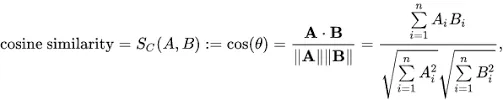

This recommendation system will be a Credits, Genres, and Keywords content-based recommender.

In [7]:
credits = pd.read_csv('the-movies-dataset/credits.csv')
keywords = pd.read_csv('the-movies-dataset/keywords.csv')

metadata = metadata.drop([19730, 29503, 35587])

In [8]:
credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [9]:
# converting IDs to integers

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')


# merging the two other dataframes into the metadata frame
# so that we can use just it. merging on IDs, meaning that they will match 
# IDs
metadata = metadata.merge(credits, on = 'id')
metadata = metadata.merge(keywords, on = 'id')

metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [10]:
from ast import literal_eval

features = ['cast', 'crew','keywords','genres']
for f in features:
  metadata[f] = metadata[f].apply(literal_eval)

In [11]:
import numpy as np

In [12]:
def get_director(x):
  for i in x:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [13]:
def get_list(x):
  if isinstance(x, list):
    names = [i['name'] for i in x] 
    if len(names)> 3:
      names = names[:3]
    return names
  return []

In [14]:
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for f in features:
  metadata[f] = metadata[f].apply(get_list)

In [15]:
metadata[['title', 'cast','director', 'keywords', 'genres']].head(1)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. Removing the spaces between words is an important preprocessing step. It is done so that your vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same. After this processing step, the aforementioned actors will be represented as "johnnydepp" and "johnnygalecki" and will be distinct to your vectorizer. Another good example where the model might output the same vector representation is "bread jam" and "traffic jam". Hence, it is better to strip off any space that is present.

In [16]:
def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(' ', '')) for i in x]
  else:
    if isinstance(x, str):
      return str.lower(x.replace(' ', ''))
    else:
      return ''

In [17]:
features = ['cast', 'keywords', 'director', 'genres']

for f in features:
  metadata[f] = metadata[f].apply(clean_data)

In [42]:
def create_soup(x):
  return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [43]:
metadata['soup'] = metadata.apply(create_soup, axis = 1 )

In [44]:
metadata[['soup']].head(2)

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...


The next steps are the same as what you did with your plot description based recommender. One key difference is that you use the CountVectorizer() instead of TF-IDF. This is because you do not want to down-weight the actor/director's presence if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense to down-weight them in this context. The major difference between CountVectorizer() and TF-IDF is the inverse document frequency (IDF) component which is present in later and not in the former.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(metadata['soup'])

In [46]:
count_matrix.shape

(46628, 73881)

In [47]:
from sklearn.metrics.pairwise import cosine_similarity


In [48]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [49]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [51]:
# metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index = metadata['title'])
                    
get_recommendations('The Dark Knight Rises', cosine_sim)


12589      The Dark Knight
10210        Batman Begins
9311                Shiner
9874       Amongst Friends
7772              Mitchell
516      Romeo Is Bleeding
11463         The Prestige
24090            Quicksand
25038             Deadfall
41063                 Sara
Name: title, dtype: object